**TỔNG QUAN:**
- Mục tiêu: phân loại các bài báo cùng chủ đề về COVID 19 dựa trên phương pháp CLUSTERING
- Các bước thực hiện:
+ Tiền xử lý: loại bỏ NA, các ký tự đặc biệt, các từ không có nhiều ý nghĩa,...
+ Vectorization: xử lý dữ liệu ngôn ngữ thành dạng số dựa trên tần suất xuất hiện các chữ trong titile của bài báo
+ PCA: giảm chiều dữ liệu
+ Tìm số cụm bằng phương pháp elbow : kết quả là 20
+ Chạy model với k = 20 và đánh giá bằng hệ số silhouette

**1)LOADING DATA**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
meta_df = pd.read_csv('/content/drive/My Drive/metadata.csv', dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head(1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN


In [ ]:
df_covid = pd.DataFrame(meta_df, columns=['sha', 'doi', 'abstract',  'authors', 'title', 'journal']).rename(columns ={'sha' : 'paper_id'}, inplace = False )

**2)DATA PREPROCESSING**

*DROPNA*

In [ ]:
#Drop N/a values
df_covid.dropna(inplace=True)

In [ ]:
df_covid.isnull().sum()

paper_id    0
doi         0
abstract    0
authors     0
title       0
journal     0
dtype: int64

In [ ]:
df_covid.describe()

,paper_id,doi,abstract,authors,title,journal
count,155949,155949,155949,155949,155949,155949
unique,155948,155946,155474,151619,154828,12091
top,04be0daf15ec0f01c8fd6f8b67acadd9487ba511,10.23750/abm.v91i4.10698,[Figure: see text],"Larsen, Reinhard",Conclusion,bioRxiv
freq,2,2,108,59,24,5044


*HANDLING MULTIPLE LANGUAGES*

WORK ON SAMPLE OF 10000 sample

In [ ]:
df = df_covid.sample(10000, random_state=42)

In [ ]:
 !pip install langdetect

     |████████████████████████████████| 983kB 4.3MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=cbee5a6096b9bcee1cc80b32d0b38925202991cd6f020a49869e8a104551b047
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


In [ ]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['title'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 10000/10000 [01:08<00:00, 146.76it/s]


In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 10000

{'af': 3,
 'ca': 14,
 'cy': 5,
 'da': 3,
 'de': 97,
 'en': 9671,
 'es': 67,
 'et': 2,
 'fi': 4,
 'fr': 58,
 'id': 2,
 'it': 29,
 'lt': 1,
 'nl': 11,
 'no': 2,
 'pl': 1,
 'pt': 7,
 'ro': 14,
 'sl': 1,
 'sv': 1,
 'tl': 6,
 'tr': 1}


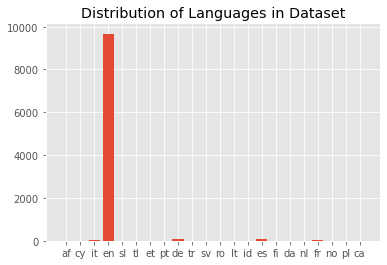

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [ ]:
#Take only paper in ENGLISH
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9671 entries, 584065 to 623814
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paper_id  9671 non-null   object
 1   doi       9671 non-null   object
 2   abstract  9671 non-null   object
 3   authors   9671 non-null   object
 4   title     9671 non-null   object
 5   journal   9671 non-null   object
 6   language  9671 non-null   object
dtypes: object(7)
memory usage: 604.4+ KB


*STOPWORDS*

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   

     |████████████████████████████████| 500.6MB 31kB/s 
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.4-cp37-none-any.whl size=501343162 sha256=e41e23da32ab34a47966b5c0a2f17b7eb41535e6fca107322c79ce806827125f
  Stored in directory: /root/.cache/pip/wheels/ea/ab/e5/fa667519032799529ce6a50944a82d6ae3603819cd07836aa2
Successfully built en-core-sci-lg


In [ ]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

In [ ]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [ ]:
#Add more stop word often used in research paper which not included in the stopwords list above
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [ ]:
#Creat function to process text data: This function will convert text to lower case, remove punctuation, and find and remove stopwords.
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
#Apply function to title
tqdm.pandas()
df["processed_text"] = df["title"].progress_apply(spacy_tokenizer)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 9671/9671 [00:40<00:00, 236.27it/s]


In [ ]:
df[['processed_text','title']].head(3)

,processed_text,title
584065,education time covid at-a-distance training ne...,Education in the Time of COVID: At-a-Distance ...
556741,novel synthesis detection method cap-associate...,A novel synthesis and detection method for cap...
556406,assessment valuation health impact fine partic...,Assessment and valuation of health impacts of ...


**Vectorization**

In [ ]:
text = df['processed_text'].values

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 4000) #max world = 4000

In [ ]:
X = vectorizer.fit_transform(text)

**PCA & CLUSTERING**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(9671, 2763)

In [ ]:
X.shape

(9671, 4000)

In [ ]:
X_reduced.shape

(9671, 2763)

**CLUSTERING**

FIND K CLUSTER USING ELBOW

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
inertia = []
for k in range(2, 31):
    k_means_model = KMeans(n_clusters = k).fit(X_reduced)
    inertia.append(k_means_model.inertia_)

KeyboardInterrupt: ignored

<function matplotlib.pyplot.show>

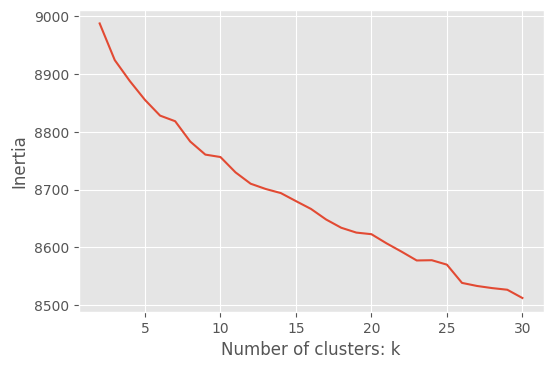

In [ ]:
from matplotlib.pyplot import figure
figure(dpi=100)
plt.plot(np.arange(2,31), inertia)
plt.xlabel("Number of clusters: k")
plt.ylabel("Inertia")
plt.show

**RUN MODEL WITH K = 20 and EVALUATE QUALITY WITH silhouette_score**

In [ ]:
k_means_model = KMeans(n_clusters = 20).fit(X_reduced)

In [ ]:
from sklearn.metrics import silhouette_score as ss

In [ ]:
labels = k_means_model.predict(X_reduced)

In [ ]:
ss(X_reduced, labels, metric = 'euclidean')

0.013836040640642141

In [ ]:
#Rerun model with k=17 and k=22
for k in [17,22]:
  k_means_model = KMeans(n_clusters = k).fit(X_reduced)
  labels = k_means_model.predict(X_reduced)
  ss_score = ss(X_reduced, labels, metric = 'euclidean')
  print(k, ss_score)

17 0.01168794623682055
22 0.012654631740061718


NX: Khi thay đổi k, hệ số silhouette giảm đi, có thể nói k = 20 đang cho kết quả tốt nhất tuy nhiên hệ số này khá gần 0 do đó có thể thấy các cụm dữ liệu không có phân tách rõ ràng

In [ ]:
df['cluster'] = labels

In [ ]:
df.head()

,paper_id,doi,abstract,authors,title,journal,language,processed_text,cluster
584065,21e285d53e9ba5f243f00ebc7239ab0ecd89955e,10.1016/j.arrct.2020.100098,Point of care ultrasound is important to the s...,"Cook, Amy E.; Inkpen, Peter",Education in the Time of COVID: At-a-Distance ...,Arch Rehabil Res Clin Transl,en,education time covid at-a-distance training ne...,4
556741,90cc93e5eac1e836f5cbce50fe92ded531045abf,10.1038/srep00126,A method is described for the detection of cer...,"Kruse, Susanne; Zhong, Silin; Bodi, Zsuzsanna;...",A novel synthesis and detection method for cap...,Sci Rep,en,novel synthesis detection method cap-associate...,18
556406,ece0ed2b949a0a8749dcd563dbe663bb44ef34c4,10.1007/s11356-021-13813-w,A novel coronavirus disease (COVID-19) continu...,"Bherwani, Hemant; Kumar, Suman; Musugu, Kavya;...",Assessment and valuation of health impacts of ...,Environ Sci Pollut Res Int,en,assessment valuation health impact fine partic...,15
491163,611b6b979ce06eccb9b910231289d8de0a843df7,10.1099/jgv.0.000663,Feline coronavirus (FCoV) causes the fatal dis...,"Tanaka, Yoshikazu; Sato, Yuka; Sasaki, Takashi",Feline coronavirus replication is affected by ...,Journal of General Virology,en,feline coronavirus replication affect cyclophi...,4
636496,ce9aab549be1361b72e9dc15efd7fb31d803b5d9,10.1016/j.heliyon.2021.e05998,The main purpose of this study is to analyze h...,"Pagliaro, Mario; Coccia, Mario",How self-determination of scholars outclasses ...,Heliyon,en,self-determination scholar outclass shrink pub...,2
